<a href="https://colab.research.google.com/github/amurtigro041/MachineLearning_Kaggle/blob/main/Demo_ILT_5_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series

This tutorial demonstrates time series forecasting using TensorFlow on sunspots dataset.

## Import TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow.keras import layers, models, optimizers

## Prepare the dataset for training

In [2]:
!wget --no-check-certificate \
    https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv \
    -O /tmp/sunspots.csv

--2024-05-03 07:18:41--  https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/Simulation/machine_learning/sunspots.csv [following]
--2024-05-03 07:18:42--  https://raw.githubusercontent.com/dicodingacademy/assets/main/Simulation/machine_learning/sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68195 (67K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  66.60K  --.-KB/s    in 0.007s  

2024-05-03 07:18:42 (8.97 MB/s) - ‘/tmp/su

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

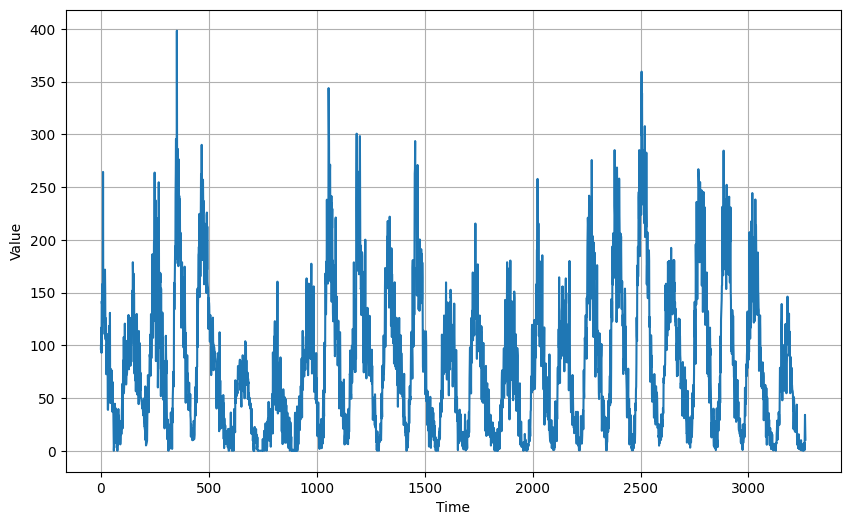

In [4]:
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
# Normalization
min=np.min(series)
max=np.max(series)
series -= min
series /= max
time=np.array(time_step)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)



In [8]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
validation_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

## Create the model

In [10]:
def create_model(window_size):
  model = models.Sequential([
    layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    layers.LSTM(60, return_sequences=True),
    layers.LSTM(60, return_sequences=True),
    layers.Dense(20, input_shape=[window_size], activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
  ])

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))

  return model

In [11]:
model = create_model(window_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 20)          1220      
                                                                 
 dense_1 (Dense)             (None, None, 10)          210       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 59881 (233.91 KB)
Trainable params: 59881 

## Train & evaluate the model

In [12]:
model.fit(train_set, epochs=100)

Epoch 1/100
92/92 [==============================] - 8s 13ms/step - loss: 0.0177
Epoch 2/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0102
Epoch 3/100
92/92 [==============================] - 1s 14ms/step - loss: 0.0089
Epoch 4/100
92/92 [==============================] - 2s 21ms/step - loss: 0.0080
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0073
Epoch 6/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0069
Epoch 7/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0066
Epoch 8/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0065
Epoch 9/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0064
Epoch 10/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0063
Epoch 11/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0062
Epoch 12/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0061
Epoch 13/100
92/92 [=====

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(validation_set))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

7/7 [==============================] - 0s 12ms/step
